# Modeling
## 1. Import cleaned data

In [72]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')
import time

import warnings
warnings.filterwarnings('ignore')

In [73]:
data_path = os.path.join(os.getcwd(),'data')
# train = pd.read_csv(os.path.join(data_path, "train.csv"))
train = pd.read_csv(os.path.join(data_path, "train_resample.csv"))
test = pd.read_csv(os.path.join(data_path, "test.csv"))

# seperate features and response
X_train, Y_train = train.iloc[:,1:], train["loan_status"] 
X_test, Y_test = test.iloc[:,1:], test["loan_status"] 

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, classification_report, accuracy_score, f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


def show_result(clf, X_train, Y_train, X_test, Y_test, pos_label):
    print("Accuracy on train set: {}".format(clf.score(X_train, Y_train)))
    print("Accuracy on test set: {}".format(clf.score(X_test, Y_test)))
    # fig = plt.figure(figsize = (12,10))
    plot_confusion_matrix(clf, X_test, Y_test,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 #normalize=normalize
                     )
    plot_confusion_matrix(clf, X_train, Y_train,
                                 #display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 #normalize=normalize
                     )
    
    Y_pred = clf.predict(X_test)
    Matrix = confusion_matrix(Y_test, Y_pred)
    
    # calculate the result of classification
    result = pd.DataFrame([[-1,-1,-1,-1]],columns=["Accuracy", "Precision", "Recall", "F1-Score"])
    result["Accuracy"] = accuracy_score(Y_test, Y_pred)
    result["Precision"] = precision_score(Y_test, Y_pred, pos_label = pos_label)
    result["Recall"] = recall_score(Y_test, Y_pred, pos_label = pos_label)
    result["F1-Score"] = f1_score(Y_test, Y_pred, pos_label = pos_label)
    return result



## 2. Normalization

In [33]:
X_train.head(10)

,term,home_ownership,emp_length,verification_status,installment,monthly_inc,PaymentToIncome,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,60,2,4,3,388.67,4333.000000,0.089700,16.43,0,0,7,0,2644,0.482,15
1,36,2,0,1,38.51,1600.000000,0.024069,10.19,0,0,9,0,6283,0.472,10
2,36,2,7,1,221.28,4666.666667,0.047417,9.11,0,1,13,0,977,0.027,32
3,36,3,0,3,167.09,4166.666667,0.040102,15.84,0,1,7,0,14576,0.684,18
4,36,3,9,1,372.12,5000.000000,0.074424,16.32,1,0,9,0,13703,0.322,37
5,36,2,9,1,156.10,5833.333333,0.026760,2.11,0,0,6,0,2663,0.222,16
6,36,3,4,1,369.08,4166.666667,0.088579,4.15,0,0,5,0,4268,0.736,5
7,36,3,5,2,735.14,8400.000000,0.087517,18.60,0,1,12,0,27773,0.529,26
8,36,3,10,3,309.42,4250.000000,0.072805,7.27,0,0,14,0,9372,0.105,22
9,36,4,10,1,257.78,7500.000000,0.034371,9.87,0,3,16,0,5163,0.040,35


In [76]:
# Z-score normalization
train_mean = X_train.iloc[:,4:].mean(axis=0)
train_std = X_train.iloc[:,4:].std(axis=0)
X_train.iloc[:,4:] = (X_train.iloc[:,4:] - train_mean) / train_std
X_test.iloc[:,4:] = (X_test.iloc[:,4:] - train_mean) / train_std
X_train.head()

,term,home_ownership,emp_length,verification_status,installment,monthly_inc,PaymentToIncome,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,60.0,2.0,4.0,3.0,0.300874,-0.247754,0.548589,0.448341,-0.326269,-0.922954,-0.538912,-0.278033,-0.692508,-0.128804,-0.627974
1,36.0,2.0,0.0,1.0,-1.432404,-0.804280,-1.135315,-0.544606,-0.326269,-0.922954,-0.064296,-0.278033,-0.458826,-0.165846,-1.088804
2,36.0,2.0,7.0,1.0,-0.527700,-0.179809,-0.536264,-0.716463,-0.326269,0.057799,0.884937,-0.278033,-0.799556,-1.814178,0.938849
3,36.0,3.0,0.0,3.0,-0.795938,-0.281625,-0.723960,0.354456,-0.326269,0.057799,-0.538912,-0.278033,0.073717,0.619428,-0.351476
4,36.0,3.0,9.0,1.0,0.218952,-0.111931,0.156652,0.430837,1.785511,-0.922954,-0.064296,-0.278033,0.017656,-0.721463,1.399679


## 3. logistic regression


Accuracy on train set: 0.6251840649500537
Accuracy on test set: 0.6251099660676134


,Accuracy,Precision,Recall,F1-Score
0,0.62511,0.91334,0.624125,0.74153


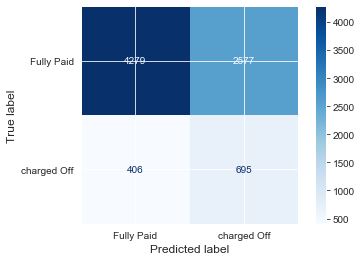

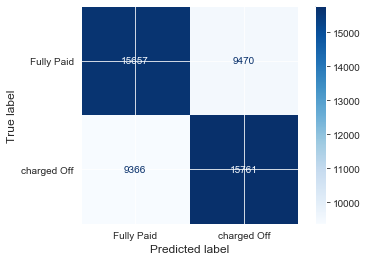

In [77]:
clf_logistic = LogisticRegression(n_jobs = -1).fit(X_train, Y_train)
show_result(clf_logistic,X_train,Y_train,X_test,Y_test, "Fully Paid")

## 3.Decision Tree

Accuracy on train set: 1.0
Accuracy on test set: 0.7152193037576976


,Accuracy,Precision,Recall,F1-Score
0,0.715219,0.870999,0.785881,0.826254


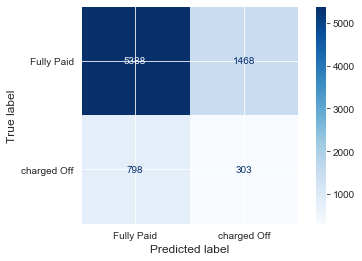

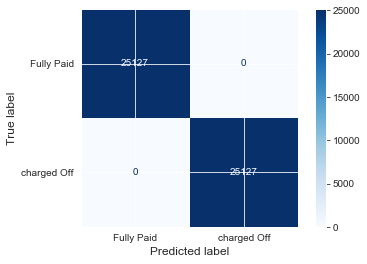

In [78]:
from sklearn import tree

clf_decisionTree = tree.DecisionTreeClassifier()
clf_decisionTree = clf_decisionTree.fit(X_train, Y_train)
show_result(clf_decisionTree,X_train,Y_train,X_test,Y_test,"Fully Paid")

# cross validation


## 4. Random Forest

Accuracy on train set: 1.0
Accuracy on test set: 0.8317204976750031


,Accuracy,Precision,Recall,F1-Score
0,0.83172,0.869327,0.947054,0.906527


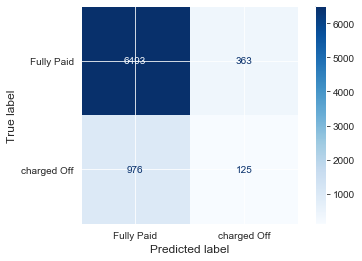

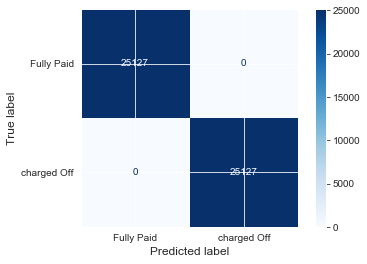

In [79]:
from sklearn.ensemble import RandomForestClassifier
clf_rf = RandomForestClassifier(n_jobs = -1)
clf_rf.fit(X_train,Y_train)
show_result(clf_rf,X_train,Y_train,X_test,Y_test,"Fully Paid")

In [83]:
### Hyperparameter tunning and cross validation

# Number of trees in Random Forest
rf_n_estimators = [100,200]
# rf_n_estimators = [int(x) for x in np.linspace(200, 1000, 5)]
# rf_n_estimators.append(1500)
# rf_n_estimators.append(2000)

# Maximum number of levels in tree
rf_max_depth = [int(x) for x in np.linspace(5, 20, 3)]
# Add the default as a possible value
# rf_max_depth.append(None)

# Number of features to consider at every split
rf_max_features = ['auto', 'sqrt', 'log2']

# Criterion to split on
rf_criterion = ['mse', 'mae']

# Minimum number of samples required to split a node
rf_min_samples_split = [int(x) for x in np.linspace(10, 100, 3)]

# Minimum decrease in impurity required for split to happen
rf_min_impurity_decrease = [0.0, 0.05, 0.1]

# Method of selecting samples for training each tree
rf_bootstrap = [True, False]

# Create the grid
rf_grid = {'n_estimators': rf_n_estimators,
               'max_depth': rf_max_depth,
#                'max_features': rf_max_features,
#                'criterion': rf_criterion,
               'min_samples_split': rf_min_samples_split,
#                'min_impurity_decrease': rf_min_impurity_decrease,
#                'bootstrap': rf_bootstrap
          }
rf_grid

{'n_estimators': [100, 200],
 'max_depth': [5, 12, 20],
 'min_samples_split': [10, 55, 100]}

In [84]:
import time

start = time.time()

# Create the model to be tuned
rf_base =  RandomForestClassifier(n_jobs = -1)

# Create the random search Random Forest
rf_random = RandomizedSearchCV(estimator = rf_base, param_distributions = rf_grid, 
                               n_iter = 200, cv = 5, verbose = 2, random_state = 9397, 
                               n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, Y_train)

end = time.time()
Time_clf_rf = end - start
print("running time: {}".format(Time_clf_rf))

# View the best parameters from the random search
rf_random.best_params_


Fitting 3 folds for each of 18 candidates, totalling 54 fits
running time: 79.24566602706909


{'n_estimators': 200, 'min_samples_split': 10, 'max_depth': 20}

Accuracy on train set: 0.9668086122497712
Accuracy on test set: 0.8250596958652758


,Accuracy,Precision,Recall,F1-Score
0,0.82506,0.868393,0.939323,0.902466


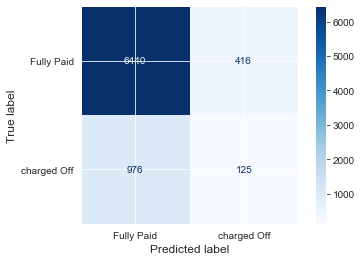

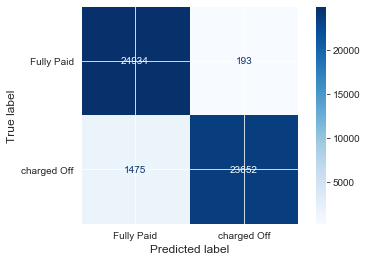

In [89]:
clf_rf2 = RandomForestClassifier(**rf_random.best_params_)#,n_jobs = -1)
clf_rf2.fit(X_train,Y_train)
show_result(clf_rf2,X_train,Y_train,X_test,Y_test,"Fully Paid")

## 5.Gradient Boosting

In [90]:
import 

# Number of trees to be used
xgb_n_estimators = [int(x) for x in np.linspace(200, 2000, 10)]

# Maximum number of levels in tree
xgb_max_depth = [int(x) for x in np.linspace(2, 20, 10)]

# Minimum number of instaces needed in each node
xgb_min_child_weight = [int(x) for x in np.linspace(1, 10, 10)]

# Tree construction algorithm used in XGBoost
xgb_tree_method = ['auto', 'exact', 'approx', 'hist', 'gpu_hist']

# Learning rate
xgb_eta = [x for x in np.linspace(0.1, 0.6, 6)]

# Minimum loss reduction required to make further partition
xgb_gamma = [int(x) for x in np.linspace(0, 0.5, 6)]

# Learning objective used
xgb_objective = ['reg:squarederror', 'reg:squaredlogerror']

# Create the grid
xgb_grid = {'n_estimators': xgb_n_estimators,
            'max_depth': xgb_max_depth,
            'min_child_weight': xgb_min_child_weight,
            'tree_method': xgb_tree_method,
            'eta': xgb_eta,
            'gamma': xgb_gamma,
            'objective': xgb_objective}
xgb_grid

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
 'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
 'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
 'tree_method': ['auto', 'exact', 'approx', 'hist', 'gpu_hist'],
 'eta': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6],
 'gamma': [0, 0, 0, 0, 0, 0],
 'objective': ['reg:squarederror', 'reg:squaredlogerror']}

In [ ]:
# Create the model to be tuned
xgb_base = XGBRegressor()

# Create the random search Random Forest
xgb_random = RandomizedSearchCV(estimator = xgb_base, param_distributions = xgb_grid, 
                                n_iter = 200, cv = 3, verbose = 2, 
                                random_state = 420, n_jobs = -1)

# Fit the random search model
xgb_random.fit(X_train_temp, y_train_temp)

# Get the optimal parameters
xgb_random.best_params_